In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

In [ ]:
# Install PyTorch
!conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.3 -c pytorch
# Install mim
!pip install -U openmim
# Install mmengine
!mim install mmengine
# Install MMCV
!mim install 'mmcv >= 2.0.0rc1'


In [4]:
!ls

drive  sample_data


In [ ]:
#!rm -rf mmsegmentation
#!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
import os
os.chdir("drive/MyDrive/661_shared_project/mmsegmentation")
!pip install -e .

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

2.1.0+cu121 True
1.2.1


In [ ]:
!pip install ftfy

In [7]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import scipy
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [8]:
def create_dataset(paths):
    ''' creates X,y datasets of all the images that have a valid fluid array/truth value'''
    x = []
    y = []

    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        print(img_tensor.shape)
        fluid_tensor = mat['manualFluid1']
        img_array = np.transpose(img_tensor, (2, 0, 1))
        manual_fluid_array = np.transpose(fluid_tensor, (2, 0, 1))

        """
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255 #normalising
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))
         """
        for idx, man in enumerate(manual_fluid_array):
          if not np.all(np.isnan(man)):
            #convert to w x h x 3
            new_img = np.reshape(img_array[idx], (img_array[idx].shape[0], img_array[idx].shape[1], 1))
            new_img = cv2.cvtColor(new_img,cv2.COLOR_GRAY2RGB)

            #we prob have to convert this array later too
            new_fluid = np.reshape(manual_fluid_array[idx], (manual_fluid_array[idx].shape[0], manual_fluid_array[idx].shape[1], 1)).astype('uint8') * 255 #astype needed for coversion
            ''' for row in range(len(new_fluid)):
                for col in range(len(new_fluid[row])):
                    if new_fluid[row][col] not in [0,1]:
                        new_fluid[row][col] = 1'''
            #new_fluid = cv2.cvtColor(new_fluid,cv2.COLOR_GRAY2RGB)

            x.append(new_img)
            y.append(new_fluid)
    return np.array(x), np.array(y)

In [ ]:
#code referenced from: https://www.kaggle.com/code/atrichatterjee7/unet-imagesegmentation

input_path = os.path.join('2015_BOE_Chiu') #uploaded folder inside mm segmentation folder
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

x_full, y_full = create_dataset(subject_path)
x_train, x_val, y_train, y_val = train_test_split(x_full, y_full, test_size=0.2, random_state=33)#42)

In [10]:
#save X imgs in img_dir

folder_train_img = "./data/oct_dataset_v2/img_dir/train/"
folder_test_img = "./data/oct_dataset_v2/img_dir/val/"
# Iterate through x_train and convert to RGB
for idx, img in enumerate(x_train):
    cv2.imwrite(folder_train_img+ "output_" + str(idx) + ".jpg", np.array(img))

for idx, img in enumerate(x_val):
    cv2.imwrite(folder_test_img+ "output_" + str(idx) + ".jpg", np.array(img))

In [11]:
#save fluid imgs (y) in annot_ir

folder_train_annot = "./data/oct_dataset_v2/annot_dir/train/"
folder_test_annot = "./data/oct_dataset_v2/annot_dir/val/"
# Iterate through x_train and convert to RGB
for idx, img in enumerate(y_train):
    cv2.imwrite(folder_train_annot+ "output_" + str(idx) + ".png", np.array(img))

for idx, img in enumerate(y_val):
    cv2.imwrite(folder_test_annot+ "output_" + str(idx) + ".png",img)

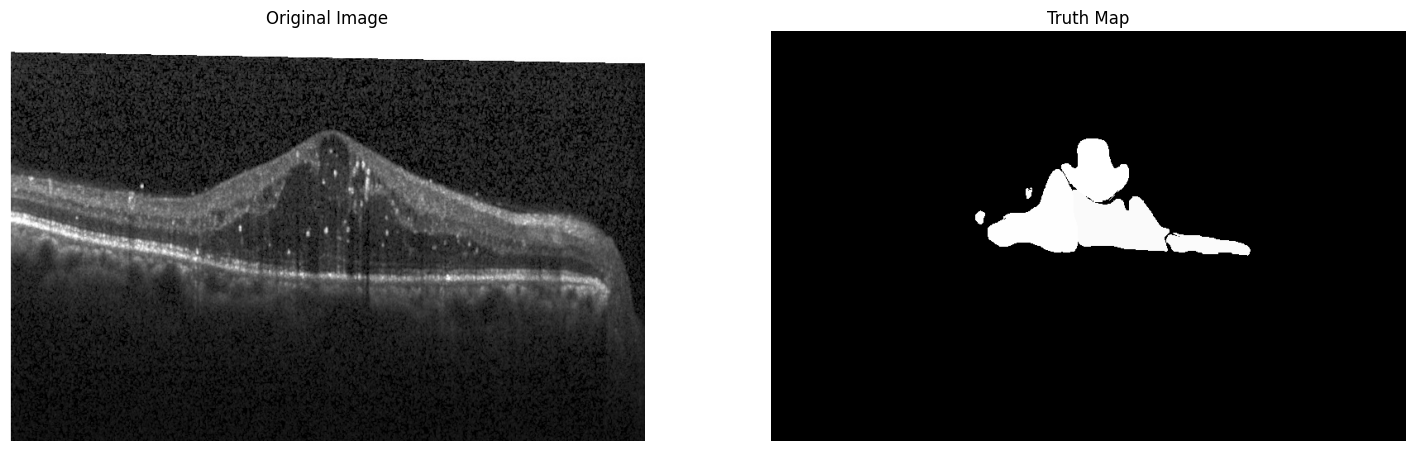

In [37]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
import cv2


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4*2))

img1 = cv2.imread('data/oct_dataset_v2/img_dir/val/output_9.jpg')

img2 = cv2.imread('data/oct_dataset_v2/annot_dir/val/output_9.png')


ax[0].imshow(img1)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].set_title("Truth Map")
ax[1].imshow(mmcv.bgr2rgb(img2))
ax[1].axis('off')

plt.show()

We need to convert the annotation into semantic map format as an image.

In [14]:
# define dataset root and directory for images and annotations
data_root = 'data/oct_dataset_v2/'
img_dir = 'img_dir'
ann_dir = 'annot_dir'
# define class and palette for better visualization
classes = ('non-fluid', 'fluid')
palette = [ [20, 118, 12], [0, 11, 123],]

In [21]:
#os.mkdir("./work_dirs/pspnet-focal-loss")

***Create Datasets***

In [23]:
import os.path as osp
import numpy as np
from PIL import Image

path1 = "./data/oct_dataset_v2/annot_dir/train/"
dir_list = os.listdir("./data/oct_dataset_v2/annot_dir/train/")
print(len(dir_list))
# convert dataset annotation to semantic segmentation map
#for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
for img in dir_list:
  #seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_map = cv2.imread(path1 + img)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(path1+ img)

88


In [24]:
import os.path as osp
import numpy as np
from PIL import Image

path1 = "./data/oct_dataset_v2/annot_dir/val/"
dir_list = os.listdir("./data/oct_dataset_v2/annot_dir/val/")
print(len(dir_list))
# convert dataset annotation to semantic segmentation map
#for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
for img in dir_list:
  #seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_map = cv2.imread(path1 + img)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(path1+ img)

22


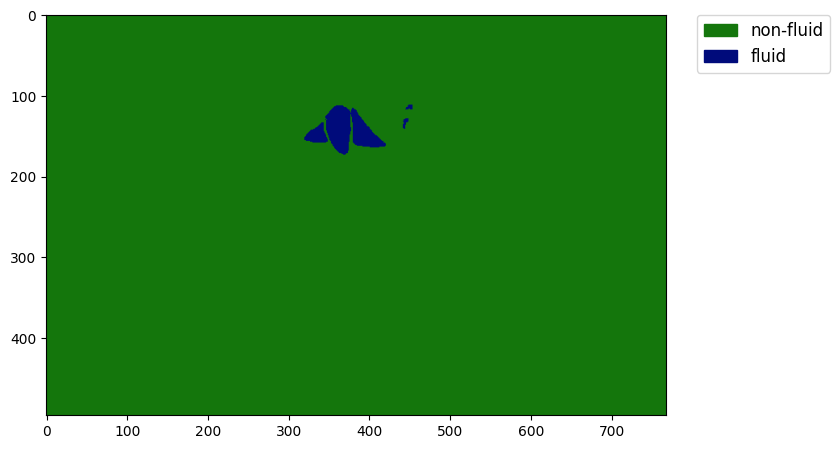

In [17]:
import matplotlib.patches as mpatches
img = Image.open('data/oct_dataset_v2/annot_dir/train/output_22.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

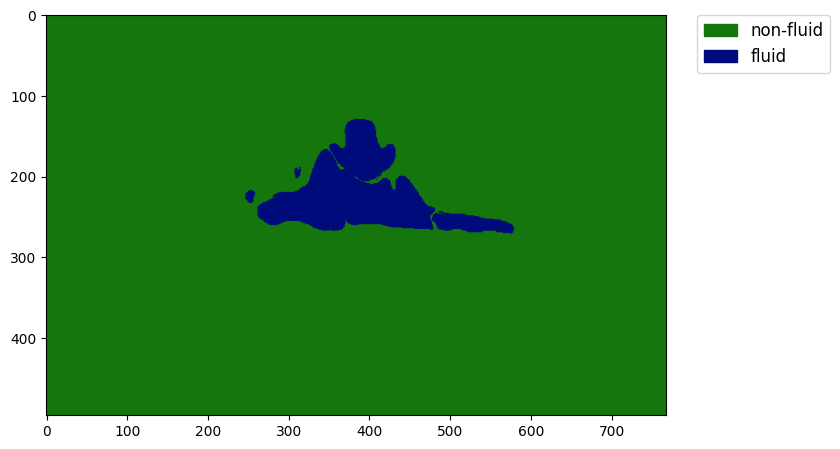

In [18]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('data/oct_dataset_v2/annot_dir/val/output_9.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()



In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class OCT_dataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', reduce_zero_label=False, **kwargs)


In [ ]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')


In [ ]:
#run for ORIGNAL
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'OCT_dataset'
cfg.data_root = data_root
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path="img_dir/train", seg_map_path="annot_dir/train")
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
#cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path="img_dir/val", seg_map_path="annot_dir/val")
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
#cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader

# Load the pretrained weights
cfg.load_from = 'fcn_unet_s5-d16_64x64_40k_drive_20201223_191051-5daf6d3b.pth'
cfg.work_dir = './work_dirs/pspnet-original'

cfg.default_hooks.checkpoint.save_best = 'mIoU'

cfg.train_cfg.max_iters = 10000
cfg.train_cfg.val_interval = 100
cfg.default_hooks.logger.interval = 50
cfg.default_hooks.checkpoint.interval = 1000

In [ ]:
#run for finetune model
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'OCT_dataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.optim_wrapper = dict(
    clip_grad=None,
    optimizer=dict(lr=0.0001, type='Adam', weight_decay=0.0005),
    type='OptimWrapper')
cfg.optimizer = dict(lr=0.0001, type='Adam', weight_decay=0.0005)

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path="img_dir/train", seg_map_path="annot_dir/train")
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
#cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path="img_dir/val", seg_map_path="annot_dir/val")
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
#cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader

cfg.model.auxiliary_head.dropout_ratio = .2

cfg.model.decode_head.dropout_ratio = .2
'''cfg.model.auxiliary_head.loss_decode.type = 'FocalLoss'
cfg.model.decode_head.loss_decode.type = 'FocalLoss'
cfg.model.decode_head.loss_decode.use_sigmoid = True
cfg.model.auxiliary_head.loss_decode.use_sigmoid = True'''

# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/pspnet-focal-loss'

cfg.train_cfg.max_iters = 10000
cfg.train_cfg.val_interval = 100
cfg.default_hooks.logger.interval = 50
cfg.default_hooks.checkpoint.interval = 1000
cfg.default_hooks.checkpoint.save_best = 'mIoU'###ENTER HERE file path to save best checkpoint
#cfg.default_hooks.checkpoint.rule="greater"


# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

### Train and Evaluation

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

In [ ]:
# start training
runner.train()

Inference with trained model

In [43]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/pspnet-adam-dropout02/best_mIoU_iter_7200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./data/oct_dataset_v2/img_dir/val/output_9.jpg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))


Loads checkpoint by local backend from path: ./work_dirs/pspnet-adam-dropout02/best_mIoU_iter_7200.pth


In [ ]:
!pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 721.3 kB/s eta 0:00:00


/content/drive/.shortcut-targets-by-id/1RFimRCiP6BsVf-gW-eboojLppckry5LY/661_shared_project/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/content/drive/.shortcut-targets-by-id/1RFimRCiP6BsVf-gW-eboojLppckry5LY/661_shared_project/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/drive/.shortcut-targets-by-id/1RFimRCiP6BsVf-gW-eboojLppckry5LY/661_shared_project/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore l

Loads checkpoint by local backend from path: ./work_dirs/pspnet-adam-dropout02/best_mIoU_iter_7200.pth


/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

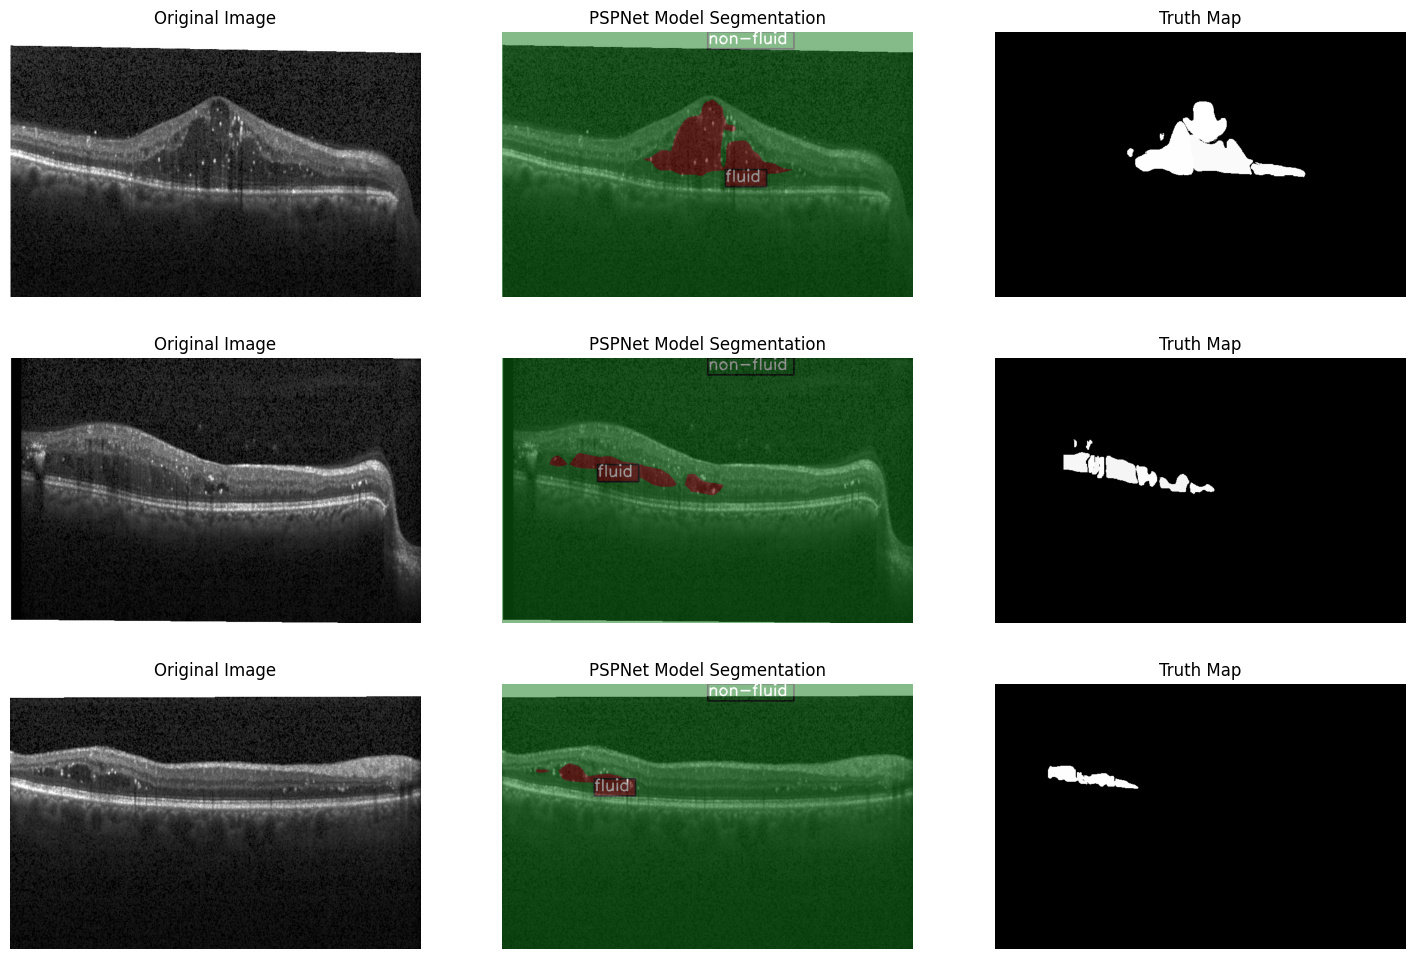

In [24]:
import mmcv
from mmseg.apis import init_model, inference_model, show_result_pyplot
from mmengine import Config

# Init the model from the config and the checkpoint
#cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
checkpoint_path = './work_dirs/pspnet-adam-dropout02/best_mIoU_iter_7200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

#chosen indexes to visualize images and fluid from subject path 1
img1 = cv2.imread('./data/oct_dataset_v2/img_dir/val/output_9.jpg')
result = inference_model(model, img1)
plt.figure(figsize=(8, 6))
vis_result1 = show_result_pyplot(model, img1, result)

map1 = cv2.imread('./data/oct_dataset_v2/annot_dir/val/output_9.png')


#chosen indexes to visualize images and fluid from subject path 1
img2 = cv2.imread('./data/oct_dataset_v2/img_dir/val/output_13.jpg')
result = inference_model(model, img2)
plt.figure(figsize=(8, 6))
vis_result2 = show_result_pyplot(model, img2, result)

map2 = cv2.imread('./data/oct_dataset_v2/annot_dir/val/output_13.png')

#chosen indexes to visualize images and fluid from subject path 1
img3 = cv2.imread('./data/oct_dataset_v2/img_dir/val/output_20.jpg')
result = inference_model(model, img3)
plt.figure(figsize=(8, 6))
vis_result3 = show_result_pyplot(model, img3, result)

map3 = cv2.imread('./data/oct_dataset_v2/annot_dir/val/output_20.png')




fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,4*3))
ax[0][0].set_title("Original Image")
ax[0][0].axis('off')
ax[0][0].imshow(img1)

ax[0][1].set_title("PSPNet Model Segmentation")
ax[0][1].axis('off')
ax[0][1].imshow(mmcv.bgr2rgb(vis_result1))

ax[0][2].set_title("Truth Map")
ax[0][2].axis('off')
ax[0][2].imshow(mmcv.bgr2rgb(map1))


ax[1][0].set_title("Original Image")
ax[1][0].axis('off')
ax[1][0].imshow(img2)

ax[1][1].set_title("PSPNet Model Segmentation")
ax[1][1].axis('off')
ax[1][1].imshow(mmcv.bgr2rgb(vis_result2))

ax[1][2].set_title("Truth Map")
ax[1][2].axis('off')
ax[1][2].imshow(mmcv.bgr2rgb(map2))



ax[2][0].set_title("Original Image")
ax[2][0].axis('off')
ax[2][0].imshow(img3)

ax[2][1].set_title("PSPNet Model Segmentation")
ax[2][1].axis('off')
ax[2][1].imshow(mmcv.bgr2rgb(vis_result3))

ax[2][2].set_title("Truth Map")
ax[2][2].axis('off')
ax[2][2].imshow(mmcv.bgr2rgb(map3))

plt.savefig("3_ex.png")

**Extra Graphs**

In [ ]:
non_fluid_iou = [99.41, 99.42,99.48, 99.47,99.46, 99.49,99.41, 99.47, 99.49, 99.47,99.44, 99.46, 99.47, 99.22, 99.46, 99.47,
                 99.44, 99.49, 99.45, 99.32, 99.47, 99., 99.48, 99.48, 99.47, 99.47, 99.47, 99.46, 99.48, 99.5, 99.45, 99.5, 99.49, 99.49,
                 99.5, 99.46, 99.44, 99.48, 99.49, 99.45, 99.46, 99.47, 99.5, 99.47, 99.46, 99.45, 99.43, 99.48, 99.47]
fluid_iou =[42.33, 40.37, 50.52, 46.49, 45.12, 53.29,53.56, 50.31, 50.87, 50.04, 45.52, 52.5, 52.51,50.74, 13.79, 50.72, 51.84,
            45.15, 53.49,47.19,33.19, 48.69, 52.15,51.06,52.3, 49.01, 50.61,48.22, 52.96, 49.46, 50.32, 46.41, 54.61, 52.29, 50.21,
            54.87, 45.16, 48.46, 52.69, 52.65, 48.42, 50.92,48.77, 52.26, 52.37, 53.34, 50.87, 53.41, 49.72, 51.63]

In [ ]:
#plt.plot(iters, non_fluid_iou,label = "Non-Fluid" )
plt.plot(iters, fluid_iou)
plt.ylabel("IoU Score")
plt.xlabel("Iterations")
plt.title("Best PSPNet Finetuned Model - Fluid IoU vs Iterations")

plt.show()